In [1]:
import respy as rp
import pandas as pd

In [2]:
print(rp.__file__)

/home/peisenha/local/anaconda3/envs/respy-development/lib/python3.7/site-packages/respy/__init__.py


## Load Existing Model

In [3]:
# Load model
params, options, data = rp.get_example_model("kw_94_two")

<AxesSubplot:xlabel='Period'>

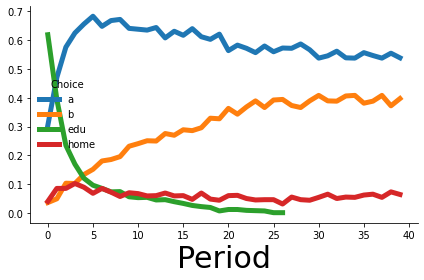

In [4]:
data.groupby("Period").Choice.value_counts(normalize=True).unstack().plot()

## Add Occupation C

1. Adjust Parameters

In [5]:
# Create occ c by copying a.
copy_a = params.loc["wage_a", ["value", "comment"]]
copy_a.index = copy_a.index.str.replace("_a", "_c")

In [6]:
# Add experience for a to occ c.
copy_a.loc["exp_a", "value"] = 0
copy_a.loc["exp_a_square", "value"] = 0
occ_c = pd.concat([copy_a], keys=["wage_c"], axis=0)
params = pd.concat([params, occ_c], axis=0)

In [7]:
# Add experience for c to occ a and b.
params.loc[("wage_a", "exp_c"), "value"] = 0
params.loc[("wage_a","exp_c_square"), "value"] = 0
params.loc[("wage_b", "exp_c"), "value"] = 0
params.loc[("wage_b","exp_c_square"), "value"] = 0

In [8]:
# Add shocks for occupation c.
shocks = params.loc["shocks_sdcorr"]
params.loc[("shocks_sdcorr", "sd_c"), "value"] = 0.4
params.loc[("shocks_sdcorr", "corr_c_a"), "value"] = 0
params.loc[("shocks_sdcorr", "corr_c_b"), "value"] = 0
params.loc[("shocks_sdcorr", "corr_edu_c"), "value"] = 0
params.loc[("shocks_sdcorr", "corr_home_c"), "value"] = 0

In [9]:
# Shocks must be have a certain order for respy to process them.
shocks_index = [
    'sd_a', 'sd_b', 'sd_c', 'sd_edu', 'sd_home', 
    'corr_b_a', 'corr_c_a', 'corr_c_b', 
    'corr_edu_a', 'corr_edu_b', 'corr_edu_c', 
    'corr_home_a', 'corr_home_b', 'corr_home_c', 'corr_home_edu']

params=params.sort_index()
shocks = params.loc["shocks_sdcorr"].reindex(shocks_index)
params = params.drop("shocks_sdcorr")
shocks = pd.concat([shocks], keys=["shocks_sdcorr"])
params = pd.concat([params, shocks], axis=0)

In [10]:
params

value  \
category            name                                  
delta               delta                        0.9500   
initial_exp_edu_10  probability                  1.0000   
lagged_choice_1_edu probability                  1.0000   
maximum_exp         edu                         20.0000   
nonpec_edu          at_least_twelve_exp_edu  -5000.0000   
                    constant                  5000.0000   
                    not_edu_last_period     -15000.0000   
nonpec_home         constant                 14500.0000   
wage_a              constant                     9.2100   
                    exp_a                        0.0330   
                    exp_a_square                -0.0005   
                    exp_b                        0.0000   
                    exp_b_square                 0.0000   
                    exp_c                        0.0000   
                    exp_c_square                 0.0000   
                    exp_edu                      0.0400   
wage_b              constant                     8.2000   
                    exp_a                        0.0220   
                    exp_a_square                -0.0005   
                    exp_b                        0.0670   
                    exp_b_square                -0.0010   
                    exp_c                        0.0000   
                    exp_c_square                 0.0000   
                    exp_edu                      0.0800   
wage_c              constant                     9.2100   
                    exp_a                        0.0000   
                    exp_a_square                 0.0000   
                    exp_b                        0.0000   
                    exp_b_square                 0.0000   
                    exp_c                        0.0330   
                    exp_c_square                -0.0005   
                    exp_edu                      0.0400   
shocks_sdcorr       sd_a                         0.4000   
                    sd_b                         0.5000   
                    sd_c                         0.4000   
                    sd_edu                    6000.0000   
                    sd_home                   6000.0000   
                    corr_b_a                     0.0000   
                    corr_c_a                     0.0000   
                    corr_c_b                     0.0000   
                    corr_edu_a                   0.0000   
                    corr_edu_b                   0.0000   
                    corr_edu_c                   0.0000   
                    corr_home_a                  0.0000   
                    corr_home_b                  0.0000   
                    corr_home_c                  0.0000   
                    corr_home_edu                0.0000   

                                                                                       comment  
category            name                                                                        
delta               delta                                                      discount factor  
initial_exp_edu_10  probability              Probability that the initial level of educatio...  
lagged_choice_1_edu probability              Probability that the first lagged choice is ed...  
maximum_exp         edu                      Maximum level of experience for education (opt...  
nonpec_edu          at_least_twelve_exp_edu        reward for going to college (tuition, etc.)  
                    constant                            constant reward for choosing education  
                    not_edu_last_period                        reward for going back to school  
nonpec_home         constant                         constant reward of non-market alternative  
wage_a              constant                                               log of rental price  
                    exp_a                                     return to same sector experie

2. Adjust Options

In [11]:
options["core_state_space_filters"] = ["period > 0 and exp_{choices_w_exp} == period and lagged_choice_1 != '{choices_w_exp}'",
 "period > 0 and exp_a + exp_b + exp_c + exp_edu == period and lagged_choice_1 == '{choices_wo_exp}'",
 "period > 0 and lagged_choice_1 == 'edu' and exp_edu == 0",
 "lagged_choice_1 == '{choices_w_wage}' and exp_{choices_w_wage} == 0",
 "period == 0 and lagged_choice_1 == '{choices_w_wage}'"]

In [12]:
options["covariates"]["exp_c_square"] = "exp_c ** 2"

### Simulate data

In [13]:
options["n_periods"] = 10

In [14]:
simulate = rp.get_simulate_func(params, options)

In [15]:
new_data = simulate(params)

<AxesSubplot:xlabel='Period'>

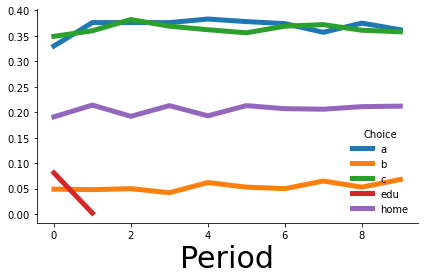

In [16]:
new_data.groupby("Period").Choice.value_counts(normalize=True).unstack().plot()